Importation of modules and functions
===

In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime
import random
import warnings
warnings.simplefilter("error")

# Functions
from implementations import *
from helpers import *

# Autoreload
# %load_ext autoreload
# %autoreload 2

# Set random seed
np.random.seed(1)

Data loading
===

In [2]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

Data filtering and standardization
===

In [3]:
data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw, ids_raw,sample_filtering = False, feature_filtering = True, replace = 'mean')

# Should not standardize all this stuff in the beginning! Only at the very end after the model has been selected!!
# Check down two inputs, where the sets are standardized.

# data, means, variance = standardize(data_)
# need to standardize test using moments calculated from training
# data_t = standardize_test(data_t_, means, variance)

data = data_.copy()
data_t = data_t_.copy()

# perform PCA

# eigVal, eigVec, sumEigVal = PCA(data, threshold = 0.7)
# data = data.dot(eigVec)
# data_t = data_t.dot(eigVec)
# print("we have reduce the number of feature with PCA to {0}".format(eigVec.shape[1]))

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 250000 samples and 23 columns


Build data into matrix form
===

In [4]:
y, tx = build_model_data(data, labels)
y_t, tx_t = build_model_data(data_t,t_labels)

Splitting into train and test set
===

In [5]:
X_train, y_train, X_test, y_test = split_data(tx, y)

# Create the standardized X_train for use of testing the model on the test set. Note that this should
# Not be done before crossvalidation, as the crossvalidation function standardizes the sets within the loops

X_train_standardized, means, variance = standardize(X_train)
X_test_standardized = standardize_test(X_test, means, variance)

print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the ratio of 0.8')

Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the ratio of 0.8


Linear regression with gradient descent (GD)
===

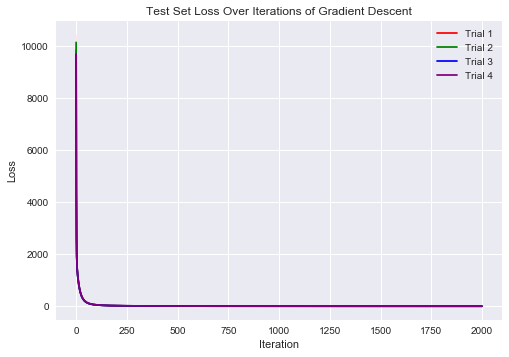

The mean of the 4 cross validation test sets is 3.2649763619044094 with variance 0.0007127728951152243. Compare this to the training set mean loss of 3.2641243599992364


In [6]:
# Initialize w vector
initial_w = np.random.rand(X_train.shape[1])
k_ = 4

# Perform linear regression by gradient descent with cross validation (k=4)
test_loss_mean, test_loss_var, vector_test_loss, train_loss_mean, w = least_squares_GD(y_train, X_train, initial_w, gamma = 0.00001, k=k_, max_iters = 2000)

# Plot the k trials losses over iterations

means_over_time = vector_test_loss.mean(axis=0)
error1 = abs(means_over_time - vector_test_loss[0])
error2 = abs(means_over_time - vector_test_loss[1])
error3 = abs(means_over_time- vector_test_loss[2])
error4 = abs(means_over_time - vector_test_loss[3])
x = np.arange(len(error1))

plt.style.use('seaborn')
# for i in np.arange(4):
#     plt.plot(x, vector_test_loss[i], label= 'Trial {}'.format(i))
plt.plot(x, vector_test_loss[0], label='Trial 1', c='red')
plt.fill_between(x, vector_test_loss[0]-error1, vector_test_loss[0]+error1,
    alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.plot(x, vector_test_loss[1], label='Trial 2', c = 'green')
plt.fill_between(x, vector_test_loss[1] - error2, vector_test_loss[1] + error2, alpha = 0.2, edgecolor='#FF3F1B', facecolor = '#12E99F')
plt.plot(x, vector_test_loss[2], label='Trial 3', c='blue')
plt.fill_between(x, vector_test_loss[2]-error3, vector_test_loss[2]+error3,
    alpha=0.2, edgecolor='#CC4F1B', facecolor='#12E2FF')
plt.plot(x, vector_test_loss[3], label='Trial 4', c='purple')
plt.fill_between(x, vector_test_loss[3]-error4, vector_test_loss[3]+error4,
    alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF00FF')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.xlim((200, 250))
# plt.ylim(10,30)
plt.title('Test Set Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()

print('The mean of the {} cross validation test sets is {} with variance {}. \
Compare this to the training set mean loss of {}'.format(k_,test_loss_mean, test_loss_var,train_loss_mean))

In [7]:
# Performing a test for prediction accuracy

w = least_squares_GD(y_train, X_train_standardized, initial_w, gamma = 0.00001, k=0, max_iters = 2000)
test_pred_lab = predict_labels(w, X_test_standardized)
train_pred_lab = predict_labels(w, X_train_standardized)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
train_accuracy = pred_accuracy(train_pred_lab, y_train)
print(test_accuracy, train_accuracy)


0.56028 0.56273


The bar chart shows potential variance in the test set. The difference between test and training accuracies is 0.002449999999999952


Text(0,0.5,'Percent Accuracy')

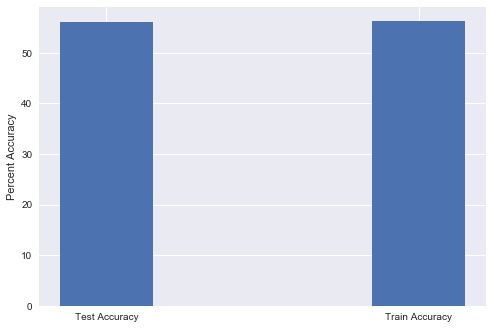

In [8]:
# Plot bar chart

print('The bar chart shows potential variance in the test set. \
The difference between test and training accuracies is {}'.format(train_accuracy - test_accuracy))
names = ['Test Accuracy', 'Train Accuracy']
values = [test_accuracy * 100, train_accuracy * 100]
plt.style.use('seaborn')
plt.bar(names, values, width = 0.3, yerr = [test_loss_var, 0])
plt.ylabel('Percent Accuracy')

Linear regression with stochastic gradient descent (SGD)
===

In [15]:
#initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_SGD(y_train, X_train, initial_w, max_iters = 250, tol = 1e-4, patience = 5) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Stochastic Gradient Descent')
plt.show()


Linear regression using least squares normal equations
===

The bar chart shows potential variance in the test set. The difference between test and training accuracies is 0.0023849999999999705


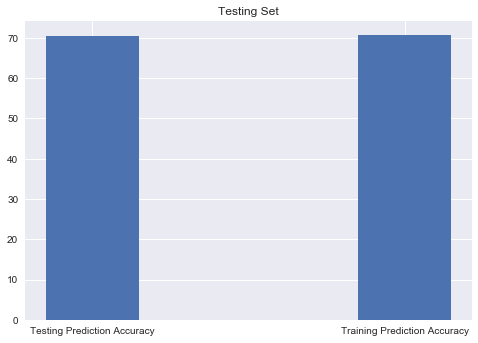

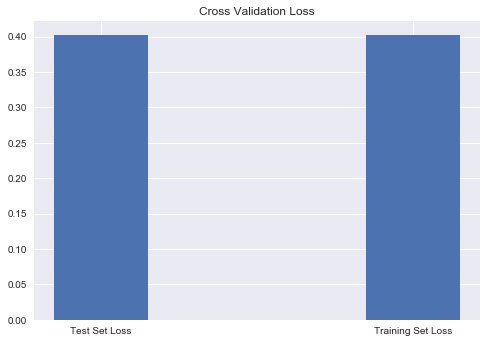

In [13]:
k_ = 4
test_loss_mean, test_loss_var, train_loss_mean, w_ = least_squares(y_train, X_train, k_)

w = least_squares(y_train, X_train, k =0)
test_pred_lab = predict_labels(w, X_test_standardized)
train_pred_lab = predict_labels(w, X_train_standardized)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
train_accuracy = pred_accuracy(train_pred_lab, y_train)
# Two subplots, the axes array is 1-d

print('The bar chart shows potential variance in the test set. \
The difference between test and training accuracies is {}'.format(train_accuracy - test_accuracy))

plt.style.use('seaborn')
plt.bar(['Testing Prediction Accuracy', 'Training Prediction Accuracy'], [test_accuracy * 100, train_accuracy * 100], width=0.3, yerr=[test_loss_var, 0])
plt.title('Testing Set')
plt.show()
plt.bar(['Test Set Loss', 'Training Set Loss'], [test_loss_mean, train_loss_mean], width=0.3, yerr=[test_loss_var, 0])
plt.title('Cross Validation Loss')
plt.show()


Linear regression using the normal equations with additional polynomial degrees
===

In [ ]:
degrees = range(1,15)
rmse_tr = np.zeros(len(degrees))
rmse_ts = np.zeros(len(degrees))
pred_tr = np.zeros(len(degrees))
pred_ts = np.zeros(len(degrees))


for ind, degree in enumerate(degrees):
    #train the model
    X_test_poly = build_poly(X_test,degree)
    X_train_poly = build_poly(X_train,degree)
    w = least_squares(y_train, X_train_poly)
    rmse_tr[ind] = (np.sqrt(2 * compute_loss(y_train, X_train_poly, w)))
    pred_tr[ind] = pred_accuracy(predict_labels(w,X_train_poly),y_train)
    
    #test the model
    
    rmse_ts[ind] = (np.sqrt(2 * compute_loss(y_test, X_test_poly, w)))
    pred_ts[ind] = (pred_accuracy(predict_labels(w, X_test_poly),y_test))
    
    # print the update
    print("degree: {d} \t rmse_ts: {a} \t  pred_ts: {b}".format(d = degree, a = rmse_ts[ind], b = pred_ts[ind]))


    

# plot the loss
plt.style.use('seaborn')
plt.plot(degrees,rmse_tr, c='blue')
plt.plot(degrees,rmse_ts, c='red')
plt.title('Loss')
plt.xlabel('Polynomial Degree')
plt.ylabel('Loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


#plot the accuracy
plt.style.use('seaborn')
plt.plot(degrees,pred_tr, c='blue')
plt.plot(degrees,pred_ts, c='red')
plt.title('Accuracy')
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


Linear regression using ridge regression
===

In [ ]:
lambdas = np.logspace(-5, 0, 15)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train, lambda_)
    rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train),y_train))
    
    
    rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test),y_test))
    
plt.style.use('seaborn')
plt.semilogx(lambdas,rmse_tr, c='blue')
plt.semilogx(lambdas,rmse_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

# print(np.max(pred))

# Logistic regression using gradient descent and stochastic gradient descent

In [ ]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y[y == -1] = 0

In [ ]:
initial_w = np.random.rand(X_train.shape[1])
losses, ws = logistic_regression(y_train, X_train, initial_w, method = 'gd', max_iters = 2000, gamma = 0.0005) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, lam = 0, method = "logistic"), ws)) # retrieve losses using test set with ws



# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels_logistic(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels_logistic(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plotCurves(losses, pred_accuracytrain, test_losses, pred_accuracytest, "Logistic Regression")

"""
plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()
plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()
"""

In [ ]:
y_sample = y[:10000] 
tx_sample = tx[:10000,:]

X_train_sample, y_train_sample, X_test_sample, y_test_sample = split_data(tx_sample, y_sample)

### Gradient descent with varying learning rates


In [ ]:
num_iter = 10000

lr = [0.00001,0.00005,0.0001,0.0005,0.001] 


test_losses  = np.zeros([len(lr),(num_iter+1)])
test_acc = np.zeros([len(lr),(num_iter+1)])
train_losses = np.zeros([len(lr),(num_iter)])
train_acc= np.zeros([len(lr),(num_iter+1)])

initial_w = np.random.rand(X_train.shape[1])

for i in range(len(lr)):
    
    l_tr, ws = logistic_regression(y_train_sample, X_train_sample, initial_w, max_iters = num_iter, gamma = lr[i], method = 'gd') # fit model, retrieve parameters ws
    train_losses[i,:] = np.array(l_tr)
    l_ts = list(map(lambda x: compute_loss(y_test_sample, X_test_sample, x, lam = 0, method = "logistic"), ws)) # retrieve losses using test set with ws
    test_losses[i,:] = np.array(l_ts)
    pred_ytrain = list(map(lambda x: predict_labels_logistic(x, X_train_sample), ws)) # Training prediction
    train_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_train_sample), pred_ytrain))
    pred_ytest = list(map(lambda x: predict_labels_logistic(x, X_test_sample), ws)) # Test prediction
    test_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_test_sample), pred_ytest))

for i in range(len(lr)):
    titre = "learning rate "+str(lr[i])
    plotCurves(train_losses[i,:], train_acc[i,:], test_losses[i,:], test_acc[i,:], titre)


In [ ]:
num_iter = 1000

lr = [0.00001,0.00005,0.0001,0.0005,0.001] 


test_losses  = np.zeros([len(lr),(num_iter+1)])
test_acc = np.zeros([len(lr),(num_iter+1)])
train_losses = np.zeros([len(lr),(num_iter)])
train_acc= np.zeros([len(lr),(num_iter+1)])

initial_w = np.random.rand(X_train.shape[1])

for i in range(len(lr)):
    
    l_tr, ws = logistic_regression(y_train_sample, X_train_sample, initial_w, max_iters = num_iter, gamma = lr[i], method = 'gd') # fit model, retrieve parameters ws
    train_losses[i,:] = np.array(l_tr)
    l_ts = list(map(lambda x: compute_loss(y_test_sample, X_test_sample, x, lam = 0, method = "logistic"), ws)) # retrieve losses using test set with ws
    test_losses[i,:] = np.array(l_ts)
    pred_ytrain = list(map(lambda x: predict_labels_logistic(x, X_train_sample), ws)) # Training prediction
    train_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_train_sample), pred_ytrain))
    pred_ytest = list(map(lambda x: predict_labels_logistic(x, X_test_sample), ws)) # Test prediction
    test_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_test_sample), pred_ytest))

for i in range(len(lr)):
    titre = "learning rate "+str(lr[i])
    plotCurves(train_losses[i,:], train_acc[i,:], test_losses[i,:], test_acc[i,:], titre)


In [ ]:
num_iter = 20000

lr = [0.00005,0.0001] 


test_losses  = np.zeros([len(lr),(num_iter+1)])
test_acc = np.zeros([len(lr),(num_iter+1)])
train_losses = np.zeros([len(lr),(num_iter)])
train_acc= np.zeros([len(lr),(num_iter+1)])

initial_w = np.random.rand(X_train.shape[1])

for i in range(len(lr)):
    
    l_tr, ws = logistic_regression(y_train_sample, X_train_sample, initial_w, max_iters = num_iter, gamma = lr[i], method = 'gd') # fit model, retrieve parameters ws
    train_losses[i,:] = np.array(l_tr)
    l_ts = list(map(lambda x: compute_loss(y_test_sample, X_test_sample, x, lam = 0, method = "logistic"), ws)) # retrieve losses using test set with ws
    test_losses[i,:] = np.array(l_ts)
    pred_ytrain = list(map(lambda x: predict_labels_logistic(x, X_train_sample), ws)) # Training prediction
    train_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_train_sample), pred_ytrain))
    pred_ytest = list(map(lambda x: predict_labels_logistic(x, X_test_sample), ws)) # Test prediction
    test_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_test_sample), pred_ytest))

for i in range(len(lr)):
    titre = "learning rate "+str(lr[i])
    plotCurves(train_losses[i,:], train_acc[i,:], test_losses[i,:], test_acc[i,:], titre)


### Stochastic Gradient Descent with varying learning rates

In [ ]:
num_iter = 10000

lr = [0.00001,0.00005,0.0001,0.0005,0.001] 


test_losses  = np.zeros([len(lr),(num_iter+1)])
test_acc = np.zeros([len(lr),(num_iter+1)])
train_losses = np.zeros([len(lr),(num_iter)])
train_acc= np.zeros([len(lr),(num_iter+1)])

initial_w = np.random.rand(X_train.shape[1])

for i in range(len(lr)):
    
    l_tr, ws = logistic_regression(y_train_sample, X_train_sample, initial_w, max_iters = num_iter, gamma = lr[i], method = 'sgd') # fit model, retrieve parameters ws
    train_losses[i,:] = np.array(l_tr)
    l_ts = list(map(lambda x: compute_loss(y_test_sample, X_test_sample, x, lam = 0, method = "logistic"), ws)) # retrieve losses using test set with ws
    test_losses[i,:] = np.array(l_ts)
    pred_ytrain = list(map(lambda x: predict_labels(x, X_train_sample), ws)) # Training prediction
    train_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_train_sample), pred_ytrain))
    pred_ytest = list(map(lambda x: predict_labels(x, X_test_sample), ws)) # Test prediction
    test_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_test_sample), pred_ytest))

for i in range(len(lr)):
    titre = "learning rate "+str(lr[i])
    plotCurves(train_losses[i,:], train_acc[i,:], test_losses[i,:], test_acc[i,:], titre)


In [ ]:
num_iter = 20000

lr = [0.00005,0.0001,0.0005] 


test_losses  = np.zeros([len(lr),(num_iter+1)])
test_acc = np.zeros([len(lr),(num_iter+1)])
train_losses = np.zeros([len(lr),(num_iter)])
train_acc= np.zeros([len(lr),(num_iter+1)])

initial_w = np.random.rand(X_train.shape[1])

for i in range(len(lr)):
    
    l_tr, ws = logistic_regression(y_train_sample, X_train_sample, initial_w, max_iters = num_iter, gamma = lr[i], method = 'sgd') # fit model, retrieve parameters ws
    train_losses[i,:] = np.array(l_tr)
    l_ts = list(map(lambda x: compute_loss(y_test_sample, X_test_sample, x, lam = 0, method = "logistic"), ws)) # retrieve losses using test set with ws
    test_losses[i,:] = np.array(l_ts)
    pred_ytrain = list(map(lambda x: predict_labels(x, X_train_sample), ws)) # Training prediction
    train_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_train_sample), pred_ytrain))
    pred_ytest = list(map(lambda x: predict_labels(x, X_test_sample), ws)) # Test prediction
    test_acc[i,:] = list(map(lambda x: pred_accuracy(x, y_test_sample), pred_ytest))
    
for i in range(len(lr)):
    titre = "learning rate "+str(lr[i])
    plotCurves(train_losses[i,:], train_acc[i,:], test_losses[i,:], test_acc[i,:], titre)
    print("best test accuracy = {0}".format(max(test_acc[i,:])))

Logistic regression using Newton's method
===

In [ ]:
# initial_w = np.random.rand(X_train.shape[1])
# losses, ws = logistic_hessian(y_train, X_train, initial_w) # fit model, retrieve parameters ws
# test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

# plt.style.use('seaborn')
# plt.plot(losses, label='Training set loss', c='blue')
# plt.plot(test_losses, label='Test set loss', c='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
# plt.legend()
# plt.show()

# # Make plot with label prediction accuracy

# pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
# pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
# pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
# pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


# plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
# plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Prediction Accuracy')
# plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
# plt.show()

"""IF YOU READ THIS: I tried doing something here so that LR is faster and more accurate,
the problem is that we can't calculate things that way, it's too big, but maybe I'll find a way
another time."""

# Regularized Logistic Regression

In [ ]:
lambdas = np.logspace(-10,0, 11)
loss_tr = []
loss_ts = []
pred_tr = []
pred_ts = []
initial_w = np.random.rand(X_train.shape[1])

# There is a runtime warning but just be patient

for ind, lambda_ in enumerate(lambdas):
    
    losses, ws = reg_logistic_regression(y_train_sample, X_train_sample, initial_w, lamb = lambda_, methods ='gd', gamma = 0.0001, max_iters=5000)
    loss_tr.append(losses[-1])
    best_w = ws[-1]
    
    pred_tr.append(pred_accuracy(predict_labels_logistic(best_w, X_train_sample),y_train_sample))
    
    test_losses = compute_loss(y_test_sample, X_test_sample, best_w, lam = lambda_, method = 'reg_logistic') # retrieve losses using test set with ws
    loss_ts.append(test_losses)
    pred_ts.append(pred_accuracy(predict_labels_logistic(best_w, X_test_sample),y_test_sample))

    
plt.style.use('seaborn')
plt.semilogx(lambdas,loss_tr, c='blue')
plt.semilogx(lambdas,loss_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

####


In [ ]:
# lamb = 0.1
# losses, ws = reg_logistic_regression(y_train, X_train, 
#                          initial_w, lamb, methods = 'gd', 
#                          gamma = 0.01, max_iters= 6000)

# test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, lam = lamb, method = 'reg_logistic'), ws)) # retrieve losses using test set with ws
# plt.style.use('seaborn')
# plt.plot(losses, label='Training set loss', c='blue')
# plt.plot(test_losses, label='Test set loss', c='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Regularized Logistic Regression: Cost Function Loss Over Iterations of Gradient Descent')
# plt.legend()
# plt.show()

# # Make plot with label prediction accuracy

# pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
# pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
# pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
# pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


# plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
# plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Prediction Accuracy')
# plt.title('Regularized Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
# plt.show()

### Using the polynomial model

In [ ]:
degree = 12
X_test_poly = build_poly(data_test,degree)
X_train_poly = build_poly(data,degree)
w = least_squares(labels, X_train_poly)
rmse_tr = (np.sqrt(2 * compute_loss(labels, X_train_poly, w)))
pred_tr = pred_accuracy(predict_labels(w,X_train_poly),labels)

test_prediction = predict_labels(w, X_test_poly)
    

In [ ]:
name = "prediction.csv"
ids = ids_test
y_pred = test_prediction
create_csv_submission(ids, y_pred, name)

# this yielded like 0.62 on kaggle

### Using logistic regression

In [ ]:
initial_w = np.ones(tx.shape[1])
y[y == -1] = 0
losses, ws = logistic_regression(y, tx, initial_w, method = 'sgd', max_iters = 6000) # fit model, retrieve parameters ws

In [ ]:
pred = tx_t.dot(ws[-1])
pred[np.where(pred <= 0.5)] = -1
pred[np.where(pred > 0.5)] = 1

name = "prediction.csv"
create_csv_submission(t_ids, pred, name)

# this yields 0.73 on kaggle

In [ ]:
initial_w = np.ones(tx.shape[1])
y[y == -1] = 0
losses, ws = reg_logistic_regression(y, tx, initial_w, lamb = 0.1, methods = 'sgd', max_iters = 20000, gamma = 0.0001)

pred = tx_t.dot(ws[-1])
pred[np.where(pred <= 0.5)] = -1
pred[np.where(pred > 0.5)] = 1

name = "prediction_2.csv"
create_csv_submission(t_ids, pred, name)